# nb-model_xg-model-neural-process-clf-dcur

In [1]:
import sys
import os
from os import sep
from os.path import dirname, realpath, exists
from pathlib import Path
from functools import partial
import logging

def get_cwd(fname, subdir, crunch_dir=realpath(Path.home()) +sep +'crunch' +sep):
    """
    Convenience function to make a directory string for the current file based on inputs.
    Jupyter Notebook in Anaconda invokes the Python interpreter in Anaconda's subdirectory
    which is why changing sys.argv[0] is necessary. In the future a better way to do this
    should be preferred..
    """
    return crunch_dir +subdir +fname

def fix_path(cwd):
    """
    Convenience function to fix argv and python path so that jupyter notebook can run the same as
    any script in crunch.
    """
    sys.argv[0] = cwd
    module_path = os.path.abspath(os.path.join('..'))
    if module_path not in sys.path:
        sys.path.append(module_path)

fname = 'nb-model_xg-model-neural-process-clf-dcur.ipynb'
dir_name = 'model'
fix_path(get_cwd(fname, dir_name +sep))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning import loggers as pl_loggers
from verification.batch_norm import BatchNormVerificationCallback
from verification.batch_gradient import BatchGradientVerificationCallback

from ipywidgets import interact, interactive, fixed
from IPython.display import display

pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 50)

from common_util import MODEL_DIR, load_json, dump_json, load_df, str_now, makedir_if_not_exists, is_valid, isnt, compose, pd_split_ternary_to_binary, df_del_midx_level, midx_intersect, pd_get_midx_level, pd_rows, df_midx_restack
from model.common import ASSETS, DATASET_DIR, XG_PROCESS_DIR, XG_DATA_DIR, XG_DIR, PYTORCH_MODELS_DIR, TEST_RATIO, VAL_RATIO, EXPECTED_NUM_HOURS
from model.pl_xgdm import XGDataModule
from model.pl_np import NPModel
from model.np_util2 import AttentiveNP
from recon.viz import *
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)

CRITICAL:root:script location: /home/kev/crunch/model/nb-model_xg-model-neural-process-clf-dcur.ipynb
CRITICAL:root:using project dir: /home/kev/crunch/


Prune the xg data down to the data of interest to use in further experiments.

In [2]:
%autoreload 1
%aimport model.np_util2, model.train_util, model.pl_np, model.pl_generic, model.metrics_util, model.model_util

In [3]:
max_epochs = None
min_epochs = 20
model_name = 'anp'
asset_name = ASSETS[0]
fdata_name = 'h_pba_moz,h_vol_moz'
ldata_name = 'dcur'
loss_type = 'clf-ce'
model_type = loss_type.split('-')[0]
monitor = 'val_accuracy' if (model_type.startswith('clf')) else 'val_mae'
num_classes = 2 if (model_type.startswith('clf')) else None

optimize_dir = {
    'val_loss': 'minimize',
    'val_mae': 'minimize',
    'val_mse': 'minimize'
}.get(monitor, 'maximize')

pl_model_fn, pt_model_fn = NPModel, AttentiveNP
model_name = f'{model_type}_{pl_model_fn.__name__}_{pt_model_fn.__name__}'
t_params = pl_model_fn.suggest_params(trial=None, num_classes=num_classes)
logging.getLogger("lightning").setLevel(logging.ERROR)
print('cuda status: {}'.format('✓' if (torch.cuda.is_available()) else '🞩'))

cuda status: ✓


In [4]:
t_params =  {
    'window_size': 1,
    'feat_dim': None,
    'train_shuffle': False,
    'epochs': 200,
    'batch_size': 256,
    'batch_step_size': 128,
    'context_size': 128,
    'train_context_in_target': False,
    'train_sample_context': False,
    'loss': loss_type,
    'class_weights': None,
    'sample_out': model_type == 'clf',
    'opt': {'name': 'adam', 'kwargs': {'lr': 1e-04}},
    'num_workers': 0,
    'pin_memory': True
}

In [5]:
fret=None
dm = XGDataModule(t_params, asset_name, fdata_name, ldata_name, fret=fret)
dm.prepare_data()
dm.setup()

In [6]:
dm.fobs

(6, 5, 8)

In [7]:
# tcn_sizes = [(31, 11), (6, 26), (5, 19), (27, 15)]
# tcn_depth = [(4, 2), (5, 3), (4, 4), (4, 3)]
# tcn_kernel_sizes = [(15, 47), (7, 39), (17, 47), (15, 15)]
# tcn_input_dropout = [(.01, .10), (0, 0), (.21, .63), (.77, .33)]
# tcn_output_dropout = [(.02, .45), (.15, .74), (.82, .69), (.64, .18)]
# tcn_global_dropout = [(.04, .35), (.08, .23), (.46, .47), (.13, 0)]

In [8]:
use_det_path = True
use_lat_path = True

params_mha = {
    'heads': 1,
    'dropout': 0.0,
    'depth': 1,
}

params_ffn_enc = {
    'out_shapes': [100],
    'act': 'relu',
    'act_output': False,
    'init': 'xavier_uniform',
}

params_ffn_dec = {
    'out_shapes': [100, 100],
    'act': None,
    'act_output': False,
    'init': 'xavier_uniform',
}

params_stcn = {
    'size': 12,
    'depth': 2,
    'kernel_sizes': 15,
    'input_dropout': 0.0,
    'output_dropout': 0.0,
    'global_dropout': 0.0,
    'global_dilation': True,
    'block_act': 'relu',
    'out_act': 'relu',
    'block_init': 'kaiming_uniform',
    'out_init': 'kaiming_uniform',
    'pad_mode': 'full'
}

m_params = {
    'ft_name': 'stcn', 'ft_params': params_stcn,
    'det_encoder_params': {
        'rt_name': 'mha', 'rt_params': params_mha,
        'xa_name': 'mha', 'xa_params': params_mha,
    },
    'lat_encoder_params': {
        'latent_size': 128,
        'rt_name': None, 'rt_params': params_mha,
        'dist_type': 'normal', 'min_std': .01, 'use_lvar': False
    },
    'decoder_params': {
        'de_name': 'ffn', 'de_params': params_ffn_dec,
        'dist_type': 'normal', 'min_std': .01, 'use_lvar': False
    },
    'use_det_path': use_det_path,
    'use_lat_path': use_lat_path,
    'sample_latent': True, # False -> reduces variability in results
    #'use_lvar': False,
    'context_in_target': False,
    'label_size': num_classes-1 if (is_valid(num_classes)) else 1,
    'out_size': num_classes if (loss_type in ('clf-ce',)) else 1
}

In [9]:
mdl = pl_model_fn(pt_model_fn, m_params, t_params, dm.fobs)

In [10]:
mdl

NPModel(
  (loss): CrossEntropyLoss()
  (model): AttentiveNP(
    (feat_transform): StackedTCN(
      (model): Sequential(
        (rb[conv2d]_0): ResidualBlock(
          (net): Sequential(
            (tl[(6, 5, 8)->(12, 1, 22)]_0_0): TemporalLayer2d(
              (layer): Sequential(
                (0): ReplicationPad2d((14, 14, 0, 0))
                (1): Conv2d(6, 12, kernel_size=(5, 15), stride=(1, 1))
                (2): ReLU()
                (3): Dropout(p=0.0, inplace=False)
              )
            )
            (tl[(12, 1, 22)->(12, 1, 50)]_0_1): TemporalLayer2d(
              (layer): Sequential(
                (0): ReplicationPad2d((28, 28, 0, 0))
                (1): Conv2d(12, 12, kernel_size=(1, 15), stride=(1, 1), dilation=(1, 2))
                (2): ReLU()
                (3): Dropout(p=0.0, inplace=False)
              )
            )
          )
          (out_act): ReLU()
          (padding): ZeroPad2d(padding=(21, 21, 0, 0), value=0.0)
          (downsamp

In [11]:
l, t = dm.val[1], dm.val[2]
if (l.shape[-1] == 2):
    l_new = np.sum(l, axis=(1, 2), keepdims=False)		# Sum label matrices to scalar values
    if (l.shape[1] > 1):
        l_new += l.shape[1]
    l = l_new
else:
    raise NotImplementedError("code to process label with given shape not written")

if (t.shape[-1] == 2):
    t_new = t[t!=0.0]
    assert len(t_new)==len(t), "target with zeros removed not equal to original"
    t = t_new
else:
    raise NotImplementedError("code to process target with given shape not written")

freq_count = np.unique(l_new, return_counts=True)[1] / len(l_new)
print(freq_count)

[0.48111332 0.51888668]


## Neural Process

In [12]:
trial_time = str_now().replace(' ', '_').replace(':', '-')
study_dir = MODEL_DIR +sep.join(['log', model_name, asset_name, dm.name]) +sep
makedir_if_not_exists(study_dir)
trial_dir = f'{study_dir}{trial_time}{sep}'

csv_log = pl.loggers.csv_logs.CSVLogger(trial_dir, name='', version='')
tb_log = pl.loggers.tensorboard.TensorBoardLogger(trial_dir, name='', \
    version='', log_graph=False)
chk_callback = pl.callbacks.ModelCheckpoint(f'{trial_dir}chk{sep}', \
    monitor=monitor, mode=optimize_dir[:3])
#es_callback = EarlyStopping(monitor=monitor, min_delta=0.00, patience=30, verbose=False, mode='min')
#ver_callbacks = (BatchNormVerificationCallback(), \
                #BatchGradientVerificationCallback())
ver_callbacks = ()

trainer = pl.Trainer(max_epochs=max_epochs or t_params['epochs'],
			min_epochs=min_epochs, logger=[csv_log, tb_log],
			callbacks=[chk_callback, *ver_callbacks],
			limit_val_batches=1.0, gradient_clip_val=0., #track_grad_norm=2,
			auto_lr_find=False, amp_level='O1', precision=16,
			default_root_dir=trial_dir, weights_summary=None,
			gpus=-1 if (torch.cuda.is_available()) else None)

In [13]:
trainer.fit(mdl, datamodule=dm)

/home/kev/miniconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Validation sanity check: 0it [00:00, ?it/s]

/home/kev/miniconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

1

## Params
### TCN decoders
* increase dropout
* decrease layers

In [14]:
bench_fname = 'benchmark.json'
if (not exists('{study_dir}{bench_fname}')):
    bench = dm.get_benchmarks()
    dump_json(bench, bench_fname, study_dir)

In [15]:
bench_res = load_json('benchmark.json', study_dir)
raw_res = load_df('metrics.csv', trial_dir, data_format='csv')

<module 'matplotlib.pyplot' from '/home/kev/miniconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

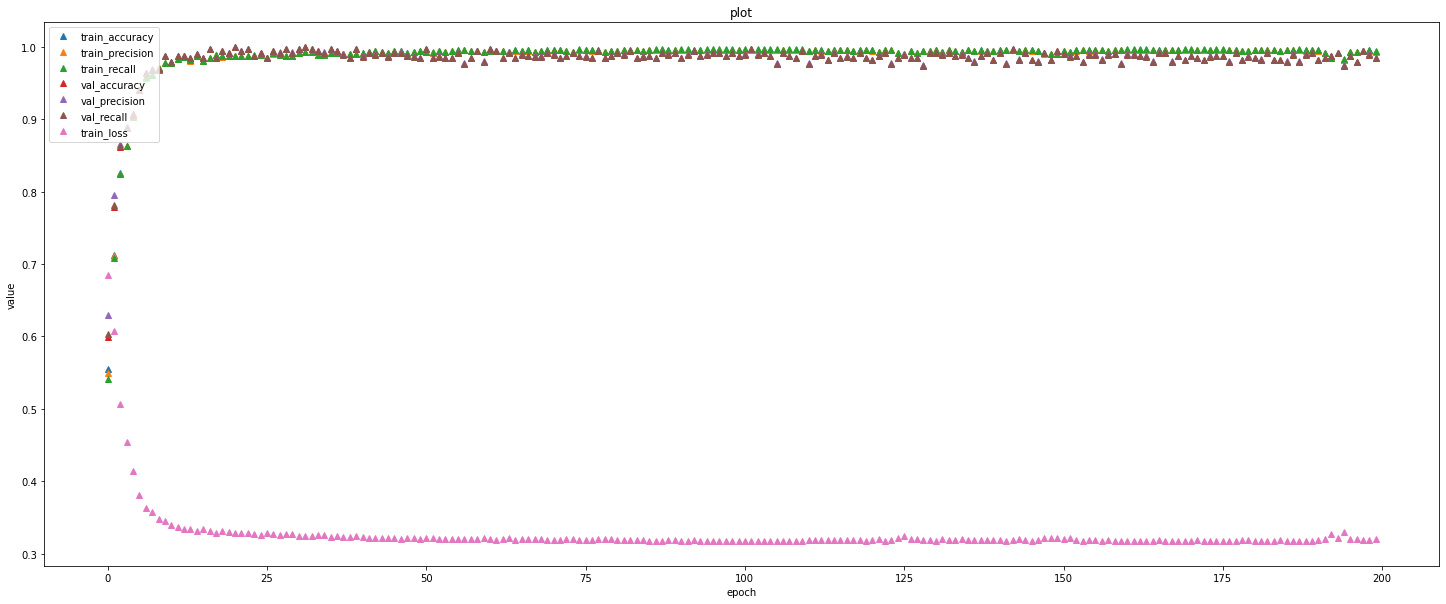

In [16]:
split1 = 'train'
split2 = 'val'
plot_df(raw_res[[f'{split1}_accuracy', f'{split1}_precision', f'{split1}_recall',
                 f'{split2}_accuracy', f'{split2}_precision', f'{split2}_recall'
                , f'{split1}_loss']], xlabel='epoch', ylabel='value')


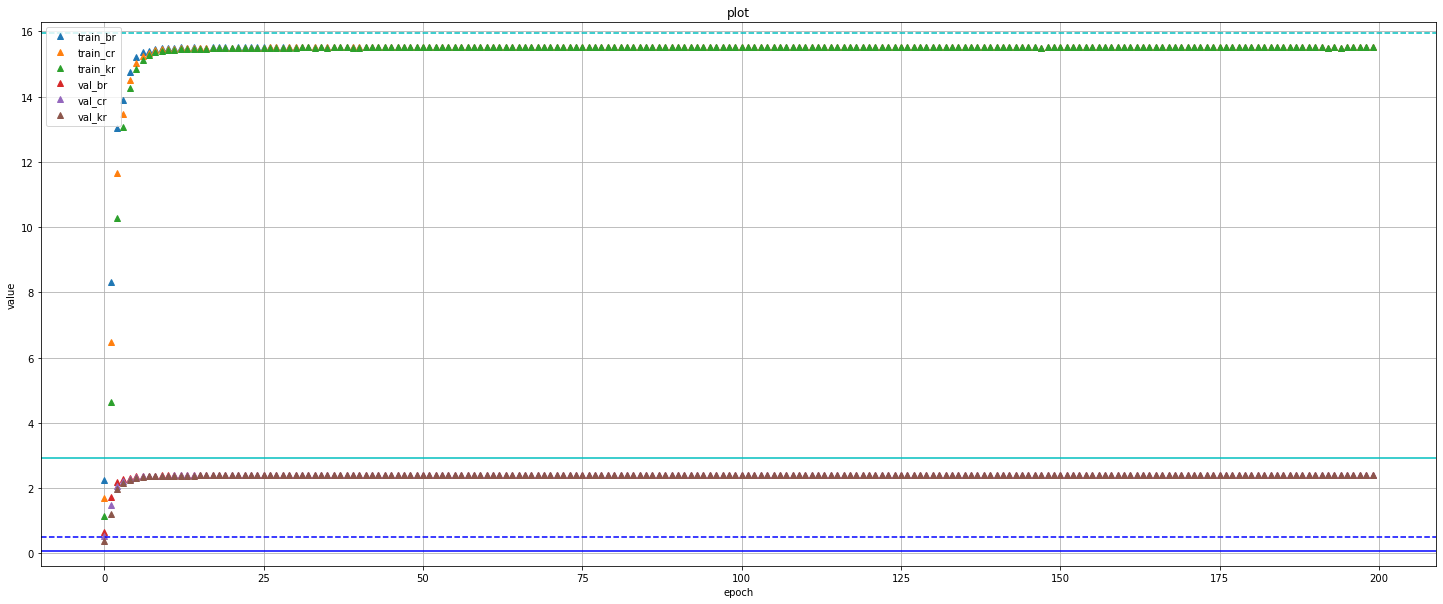

In [17]:
split1 = 'train'
split2 = 'val'
plot_df(raw_res[[f'{split1}_br', f'{split1}_cr', f'{split1}_kr',
                 f'{split2}_br', f'{split2}_cr', f'{split2}_kr']], xlabel='epoch', ylabel='value')
plt.axhline(y=bench_res[f'{split1}_bs'], linestyle='--', color='b')
plt.axhline(y=bench_res[f'{split1}_os'], linestyle='--', color='c')
plt.axhline(y=bench_res[f'{split2}_bs'], linestyle='-',  color='b')
plt.axhline(y=bench_res[f'{split2}_os'], linestyle='-',  color='c')
plt.grid()
plt.show()

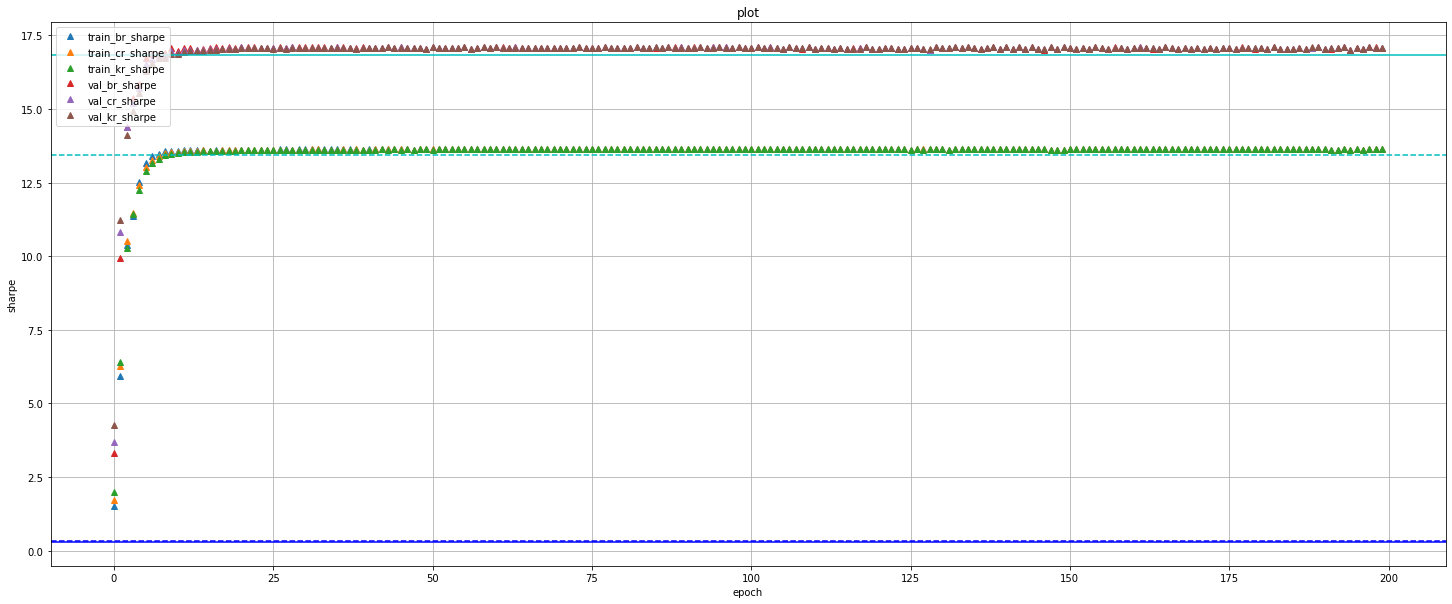

In [18]:
split1 = 'train'
split2 = 'val'
plot_df(raw_res[[f'{split1}_br_sharpe', f'{split1}_cr_sharpe', f'{split1}_kr_sharpe',
                 f'{split2}_br_sharpe', f'{split2}_cr_sharpe', f'{split2}_kr_sharpe']], xlabel='epoch', ylabel='sharpe')
plt.axhline(y=bench_res[f'{split1}_bs_sharpe'], linestyle='--', color='b')
plt.axhline(y=bench_res[f'{split1}_os_sharpe'], linestyle='--', color='c')
plt.axhline(y=bench_res[f'{split2}_bs_sharpe'], linestyle='-',  color='b')
plt.axhline(y=bench_res[f'{split2}_os_sharpe'], linestyle='-',  color='c')
plt.grid()
plt.show()

In [25]:
raw_res[[f'{split1}_br', f'{split1}_cr', f'{split1}_kr',
                 f'{split2}_br', f'{split2}_cr', f'{split2}_kr']]

,train_br,train_cr,train_kr,val_br,val_cr,val_kr
epoch,,,,,,
0,2.254278,1.703864,1.153450,NaN,NaN,NaN
0,NaN,NaN,NaN,0.670562,0.525421,0.380280
1,8.330029,6.486456,4.642883,NaN,NaN,NaN
1,NaN,NaN,NaN,1.735652,1.477001,1.218350
2,13.055010,11.674150,10.293289,NaN,NaN,NaN
...,...,...,...,...,...,...
197,NaN,NaN,NaN,2.399131,2.399141,2.399152
198,15.524746,15.524581,15.524415,NaN,NaN,NaN
198,NaN,NaN,NaN,2.398154,2.398067,2.397980


In [22]:
bench_res[f'{split2}_os_sharpe']

16.826688766479492

In [20]:
raw_res[[f'{split1}_br_sharpe', f'{split1}_cr_sharpe', f'{split1}_kr_sharpe',
                 f'{split2}_br_sharpe', f'{split2}_cr_sharpe', f'{split2}_kr_sharpe']]

,train_br_sharpe,train_cr_sharpe,train_kr_sharpe,val_br_sharpe,val_cr_sharpe,val_kr_sharpe
epoch,,,,,,
0,1.508765,1.706813,1.977935,NaN,NaN,NaN
0,NaN,NaN,NaN,3.320699,3.703476,4.270836
1,5.924299,6.282292,6.416754,NaN,NaN,NaN
1,NaN,NaN,NaN,9.925164,10.819033,11.225186
2,10.399680,10.503846,10.268353,NaN,NaN,NaN
...,...,...,...,...,...,...
197,NaN,NaN,NaN,17.107798,17.107986,17.108145
198,13.639297,13.639050,13.638824,NaN,NaN,NaN
198,NaN,NaN,NaN,17.092741,17.091442,17.090155
